## Part 1: NYC taxi data

### Basic Questions

1. What is the distribution of number of passengers per trip? (trips)
2. What is the distribution of payment_type? (fares)
3. What is the distribution of fare amount? (fares)
4. What is the distribution of tip amount? (fares)
5. What is the distribution of total amount? (fares)
6. What are top 5 busiest hours of the day? (trips/fares)
7. What are the top 10 busiest locations of the city? (trips)
8. Which trip has the highest standard deviation of travel time? (trips)
9. Which trip has most consistent fares? (fares)

### Open Questions

1. In what trips can you confidently use respective means as measures of central tendency
to estimate fare, time taken, etc.
2. Can we build a model to predict fare and tip amount given pick up and drop off
coordinates, time of day and week?
3. If you were a taxi owner, how would you maximize your earnings in a day?
4. If you were a taxi owner, how would you minimize your work time while retaining the
average wages earned by a typical taxi in the dataset?
5. If you run a taxi company with 10 taxis, how would you maximize your earnings?

## Part 2: Open showcase
After the presentation of you results for “NYC taxi data” case, you’ll have the opportunity to present your
own work for 15 minutes.
Please illustrate with an achievement of your choice (e.g. publication, participation in the community,
portfolio, open repository, etc).

### Available Data

**Note**: many column names begin with a white space!

The **trip**-related data points are the following:

* 'medallion',
* ' hack_license',
* ' vendor_id',
* ' rate_code',
* ' store_and_fwd_flag',
* ' pickup_datetime',
* ' dropoff_datetime',
* ' passenger_count',
* ' trip_time_in_secs',
* ' trip_distance',
* ' pickup_longitude',
* ' pickup_latitude',
* ' dropoff_longitude',
* ' dropoff_latitude'

and the **fare** CSV file contains the columns as below

* 'medallion',
* ' hack_license',
* ' vendor_id',
* ' pickup_datetime',
* ' payment_type',
* ' fare_amount',
* ' surcharge',
* ' mta_tax',
* ' tip_amount',
* ' tolls_amount',
* ' total_amount'

In [4]:
import pandas as pd
import re
import seaborn as sns
import arrow
import time
from collections import Counter, defaultdict, namedtuple
import geopandas as gpd
import numpy as np
from geopy.geocoders import Nominatim

sns.set_style("whitegrid")

nom = Nominatim(user_agent='app', timeout=10)

In [40]:
class Taxi:
    
    def __init__(self, trip_file, fare_file):
        
        self.trip_file = trip_file
        self.fare_file = fare_file
        
        Location = namedtuple('Location', 'lng lat')
        
        self.EMP_STATE_BUILDING = Location(lng=-73.9856, lat=40.7484)
        
        self.extreme_trip_index = None
        self.popular_locations = None
        self.AV_TRIP_TIME = None
        self.STD_TRIP_TIME = None
        
        self.trip_def_cols = ['medallion', ' pickup_datetime']
        self.location_cols = [' pickup_longitude', ' pickup_latitude', ' dropoff_longitude', ' dropoff_latitude']
        self.amount_cols = [' fare_amount', ' tip_amount', ' total_amount']
        self.payment_type_cols = [' payment_type']
        
        self.distros = defaultdict(lambda: defaultdict(int))
        
    def fix_coords(self, c, lat_lng):
        
        """
        returns the original longitude or latitude rounded to 3 decimal digits if their values are not too far
        from the Empire State Building; otherwise returns None
        
        we are being very generous here weeding out only the most remote locations (0 decimal places 
        i.e. something lik 100km away) - 
        see https://en.wikipedia.org/wiki/Decimal_degrees
        """
        
        c_ = 'lng' if lat_lng == 'longitude' else 'lat' if lat_lng == 'latitude' else None
        
        if not c_:
            raise Exception(f'{self.fix_coords.__name__}: argument lat_lng is neither latitude nor longitude!')
            
        try:
            return round(float(c),3) if abs(float(c) - getattr(self.EMP_STATE_BUILDING, c_)) < 1 else None
        except:
            pass
        
    def get_and_process_data(self, show_counts=False):
        
        self.trips = pd.read_csv('data/' + self.trip_file)
        
        if show_counts:
            print(f'cabs: {self.trips["medallion"].nunique():,}')
            print(f'drivers: {self.trips[" hack_license"].nunique():,}')
            # note that the date format is 2013-04-04 18:47:45
            print(f'days: {self.trips[" pickup_datetime"].apply(lambda x: arrow.get(str(x), "YYYY-MM-DD")).nunique():,}')
        
        self.trips[[' pickup_longitude', ' dropoff_longitude']] = self.trips[[' pickup_longitude', ' dropoff_longitude']].applymap(lambda x: self.fix_coords(c=x, lat_lng='longitude'))
        self.trips[[' pickup_latitude', ' dropoff_latitude']] = self.trips[[' pickup_latitude', ' dropoff_latitude']].applymap(lambda x: self.fix_coords(c=x, lat_lng='latitude'))
        
        pickup_avail_mask = self.trips[' pickup_longitude'].notnull() & self.trips[' pickup_latitude'].notnull()
        self.trips['pickup_loc'] = '(' + self.trips[' pickup_longitude'].astype(str) + ', ' + self.trips[' pickup_latitude'].astype(str) + ')'
        self.trips['pickup_loc'] = self.trips['pickup_loc'].where(pickup_avail_mask, None)
                  
        dropoff_avail_mask = self.trips[' dropoff_longitude'].notnull() & self.trips[' dropoff_latitude'].notnull()
        self.trips['dropoff_loc'] = '(' + self.trips[' dropoff_longitude'].astype(str) + ', ' + self.trips[' dropoff_latitude'].astype(str) + ')'
        self.trips['dropoff_loc'] = self.trips['dropoff_loc'].where(dropoff_avail_mask, None)
                  
        self.trips = self.trips.drop
        
        return self
        
    def _round_coords(self, coord_tuple, dec=3):
        
        """
        rounds longitude and latitude in the coordinate tuple to dec decimal places and returns the result
        as a comma-separated string
        
        example: input is (-73.99283982, 32.8832), the result is '-73.992, 32.883'
        """
        
        if not isinstance(coord_tuple, tuple):
            return None
        
        return ', '.join([str(round(coord_tuple[0], dec)), str(round(coord_tuple[1],dec))])

    def get_trip_stats(self, rows_at_once=50000):
        
        """
        calculates 
        
            - the number of passengers per trip
            - top 5 busiest hours of the day
            - top 10 busiest locations
            - trip with the highest std of travel time
            
        these can be used to answer questions 
        
        1. What is the distribution of number of passengers per trip? (trips)
        6. What are top 5 busiest hours of the day? (trips/fares)
        7. What are the top 10 busiest locations of the city? (trips)
        8. Which trip has the highest standard deviation of travel time? (trips)
        """
        
        # trip is defined by (medallion, pickup_datetime)
        
        useful_columns = ['medallion', ' pickup_datetime', ' passenger_count', 
                          ' pickup_longitude', ' pickup_latitude', ' dropoff_longitude', 
                          ' dropoff_latitude', ' trip_time_in_secs']
        
        travel_times_sec = list()
        
        for i, d in enumerate(pd.read_csv('data/' + self.trip_file, chunksize=rows_at_once, 
                                          usecols=useful_columns)):
            for row in d.groupby(['medallion', ' pickup_datetime']).sum().iterrows():
                self.distros['passengers'][row[0]] += row[1][' passenger_count']
                self.distros['pickup_hrs'][arrow.get(row[0][1]).hour] += 1
                
                self.distros['loc'][self._round_coords((row[1][' pickup_latitude'], row[1][' pickup_longitude']))] += 1
                self.distros['loc'][(round(row[1][' dropoff_latitude'],3), round(row[1][' dropoff_longitude'],3))] += 1
                
                travel_times_sec.append(row[1][' trip_time_in_secs'])
                
            if i and (i%10 == 0):
                print(f'done {i*rows_at_once:,} rows..')
                
        self.STD_TRIP_TIME = np.std(travel_times_sec)
        self.AV_TRIP_TIME = np.mean(travel_times_sec)
        
        self.extreme_trip_index = travel_times_sec.index(max(travel_times_sec, key=lambda x: abs(x - self.AV_TRIP_TIME)))
        
        self.popular_locations = sorted([(','.join([str(k[0]), str(k[1])]), v) 
                                   for k, v in self.distros['loc'].items()], key=lambda x: x[1], reverse=True)
        
                
        return self
    
    def get_fare_stats(self, rows_at_once=50000):
        
        """
        2. What is the distribution of payment_type? (fares)
        3. What is the distribution of fare amount? (fares)
        4. What is the distribution of tip amount? (fares)
        5. What is the distribution of total amount? (fares)
        9. Which trip has most consistent fares? (fares)
        """
        
        # we don't need all columns to answer the questions, just these:
        
        self.fares = pd.read_csv('data/' + self.fare_file, usecols=self.trip_def_cols + self.amount_cols + self.payment_type_cols)
                  
        self.fare_distros = self.fares[self.trip_def_cols + self.amount_cols] \
                                    .groupby(self.trip_def_cols) \
                                    .sum() \
                                    .reset_index(drop=True)
        
        return self
    
    def get_most_consistent_trip(self):
        
        self.trips_and_fares = pd.read_csv('data/' + self.trip_file, usecols=self.trip_def_cols + self.location_cols) \
        .join(pd.read_csv('data/' + self.fare_file, usecols=self.trip_def_cols + self.amount_cols).set_index(self.trip_def_cols),
              on = self.trip_def_cols, how='inner').drop(['medallion', ' pickup_datetime'], axis=1)
        
        self.trips_and_fares[self.location_cols] = self.trips_and_fares[self.location_cols].applymap(lambda coord: round(coord,3))
        
#         av_pick_long = self.trips_and_fares[' pickup_longitude'].astype(float).mean()
        
#         self.trips_and_fares[abs(self.trips_and_fares[' pickup_longitude'].astype(float) - av_pick_long) < 5]
        
        self.trips_and_fares['pickup_loc'] = '(' + (self.trips_and_fares[' pickup_longitude'].astype(str) + ', ' + self.trips_and_fares[' pickup_latitude'].astype(str)) + ')'
        self.trips_and_fares['dropoff_loc'] = '(' + (self.trips_and_fares[' dropoff_longitude'].astype(str) + ', ' + self.trips_and_fares[' dropoff_latitude'].astype(str)) + ')'
       
        self.trips_and_fares = self.trips_and_fares.drop(self.location_cols, axis=1)
        
        # we only consider trips made 5 times or more
        c_ = self.trips_and_fares[['pickup_loc', 'dropoff_loc', ' fare_amount']].groupby(['pickup_loc', 'dropoff_loc']).count()
        c_.columns = ['n']
        c_ = c_[c_['n'] >= 5]
        print(c_.head())
        
        self.fare_stds = self.trips_and_fares.join(c_, on=['pickup_loc', 'dropoff_loc'], how='inner').groupby(['pickup_loc', 'dropoff_loc']).std(ddof=0)
        
#         self.fare_stds = self.fare_stds[self.fare_stds[' total_amount'].astype(float) > 0]
        
        return self
        
        
        

In [41]:
if __name__ == '__main__':
    
    t0 = time.time()
    tx = Taxi(trip_file='trip_data_4.csv', fare_file='trip_fare_4.csv').get_and_process_data()
#     .get_most_consistent_trip().get_trip_stats(rows_at_once=50000)
    t1 = time.time()
    m, s = divmod(t1-t0, 60)
    print(f'elapsed time: {m:.0f} m {s:.0f} s')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


elapsed time: 2 m 47 s


In [42]:
tx.trips.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_loc
0,91F6EB84975BBC867E32CB113C7C2CD5,AD8751110E6292079EB10EB9481FE1A6,CMT,1,N,2013-04-04 18:47:45,2013-04-04 19:00:25,1,759,2.5,-73.958,40.765,-73.976,40.786,"(-73.958, 40.765)"
1,EC34CD1B3797DFAFF3FE099BA87B6656,8FE6A4AEDF89B6B4E19D2377FD3FB7D7,CMT,1,N,2013-04-05 07:08:34,2013-04-05 07:17:34,1,540,1.6,NaN,NaN,NaN,NaN,None
2,C1B9DA774DC2BBC6DE27CE994E7F44A0,E1B595FD55E4C82C1E213EB17438107A,CMT,1,N,2013-04-04 17:59:50,2013-04-04 18:21:48,1,1318,3.6,-73.983,40.755,-74.009,40.715,"(-73.983, 40.755)"
3,9BA84250355AB3FC031C9252D395BF8A,16BB0D96A0DCC853AEC7F55C8D6C71E0,CMT,1,N,2013-04-04 18:12:01,2013-04-04 18:25:24,1,799,1.9,-73.978,40.763,-73.956,40.777,"(-73.978, 40.763)"
4,205A696DF62AD03C88DA8C5EC5248639,579C41EA5EC846F8B641A42F9EE3E855,CMT,1,N,2013-04-04 20:12:57,2013-04-04 20:29:55,1,1017,3.6,-74.006,40.745,-73.962,40.761,"(-74.006, 40.745)"


In [19]:
tx.fare_stds[tx.fare_stds[' fare_amount'] > 5]

fare_amount   tip_amount   total_amount
pickup_loc        dropoff_loc                                                
(-1.65, 0.0)      (0.0, 0.0)            16.000000     4.330000      22.745000
(-67.427, 44.093) (-67.427, 44.093)     12.250000     3.530000      18.445000
(-68.118, 38.548) (-68.118, 38.548)      9.902651     1.967232      11.982901
(-7.583, 40.754)  (0.0, 0.0)             8.750000     0.000000      11.150000
(-71.3, 41.454)   (0.0, 41.454)          7.556454     1.171408       7.732671
(-71.308, 41.454) (0.0, 41.454)          7.701010     2.250679      11.798976
(-71.309, 41.454) (-71.309, 41.454)      8.314415     1.625388       9.300261
                  (-71.31, 41.454)      22.500000     0.925000      26.090000
                  (0.0, 41.454)          7.239489     1.653668       8.432837
(-72.347, 51.459) (-72.347, 51.459)      5.750000     0.940000       6.690000
(-72.834, 40.971) (-72.834, 40.971)     12.276049     2.541000      17.048229
(-72.935, 41.304) (-72.935, 41.304)    116.672619     0.000000     116.201214
(-73.129, 40.921) (-73.129, 40.921)     10.000000     0.000000      10.000000
(-73.171, 40.815) (-73.171, 40.815)     29.391155     8.124038      36.136685
(-73.364, 40.775) (-73.364, 40.775)     81.250000    20.625000     101.625000
(-73.422, 40.729) (-73.422, 40.729)     10.000000    10.000000      20.000000
(-73.422, 40.784) (-73.422, 40.784)      9.013878    12.825755      15.516121
(-73.426, 41.147) (-73.426, 41.147)     78.500000     0.000000      78.500000
(-73.436, 40.835) (-73.436, 40.835)     61.250000     7.500000      68.500000
(-73.441, 40.735) (-73.441, 40.735)     13.000000     7.500000       5.500000
(-73.443, 40.735) (-73.443, 40.735)     59.760000    12.250000      72.010000
(-73.444, 40.782) (-73.444, 40.782)     24.000000    12.700000      11.300000
(-73.444, 41.077) (-73.444, 41.077)     17.500000     9.600000      27.100000
(-73.447, 40.785) (-73.447, 40.785)     46.000000     6.000000      52.000000
(-73.467, 40.796) (-73.467, 40.796)     32.500000    25.000000       7.250000
(-73.474, 40.764) (-73.474, 40.764)     19.000000     0.000000      18.750000
(-73.484, 40.813) (-73.484, 40.813)     13.005000     2.500000      15.505000
(-73.5, 40.825)   (-73.5, 40.825)       47.530747    10.819273      59.374269
(-73.504, 40.674) (-73.504, 40.674)     73.750000     0.000000      75.915000
(-73.521, 40.711) (-73.521, 40.711)     11.887232     2.282433      13.951753
...                                           ...          ...            ...
(0.0, 40.743)     (0.0, 0.0)             7.254309     1.779747       7.956444
(0.0, 40.746)     (0.0, 0.0)             9.250000     2.400000      11.650000
(0.0, 40.748)     (0.0, 0.0)            19.027758     0.942809      21.040431
                  (0.0, 40.748)          6.114645     0.942809       5.338539
(0.0, 40.753)     (0.0, 40.753)         18.174072     1.479020      21.285422
(0.0, 40.754)     (-73.985, 40.754)     16.081987     2.385760      19.503380
                  (0.0, 0.0)            15.117271     4.022492      19.880494
                  (0.0, 40.754)          6.228936     1.841814       7.979628
(0.0, 40.758)     (0.0, 0.0)             9.750000     4.330000      16.745000
(0.0, 40.76)      (0.0, 40.76)          20.506097     0.000000      20.034692
(0.0, 40.763)     (0.0, 0.0)             6.250000     0.950000       7.200000
(0.0, 40.765)     (0.0, 0.0)            28.500000     0.500000      33.375000
(0.0, 40.769)     (-73.99, 40.752)      12.500000     3.730000      18.645000
                  (0.0, 40.769)          8.376555     3.479428      14.061892
(0.0, 40.77)      (-73.863, 40.77)       5.777110     0.000000       5.704987
                  (0.0, 0.0)            13.650895     3.016220      16.971514
(0.0, 40.771)     (0.0, 0.0)             6.973163     0.433013       8.649675
(0.0, 40.778)     (-73.982, 40.778)     11.500000     2.600000      14.100000
(0.0, 40.786)     (0.0, 40.786)         12.750000     2.8300

In [44]:
tx.trips_and_fares['pick_loc'] = '(' + (tx.trips_and_fares[' pickup_longitude'].astype(str) + ', ' + tx.trips_and_fares[' pickup_latitude'].astype(str)) + ')'

In [17]:
tx._round_coords((-22.121233, 33.222323))

'-22.121, 33.222'

In [16]:
sns.set(rc={'figure.figsize':(12,6)})

sns.barplot(data=pd.DataFrame.from_dict(Counter(tx.distros['passengers'].values()), orient='index') \
            .reset_index()
            .rename(columns={'index': 'passengers', 0: 'count'}), x='passengers', y='count')

ValueError: Could not interpret input 'count'

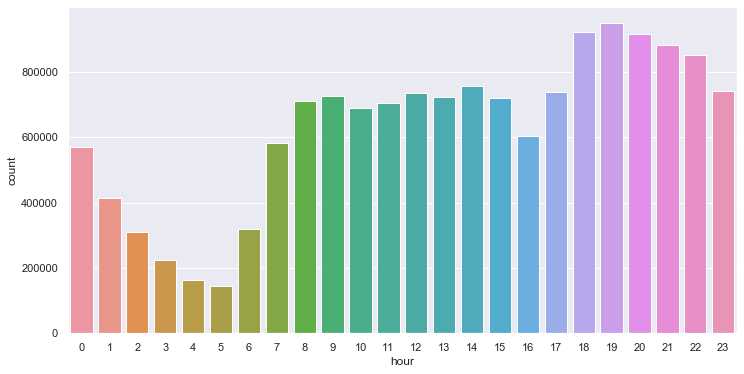

In [8]:
sns.barplot(data=pd.DataFrame.from_dict(tx.distros['pickup_hrs'], orient='index') \
            .reset_index() \
            .rename(columns={'index': 'hour', 0: 'count'}), x='hour', y='count')

In [9]:
df = gpd.read_file(gpd.datasets.get_path('nybb'))

In [10]:
df.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,(POLYGON ((970217.0223999023 145643.3322143555...
1,4,Queens,896344.047763,3.045213e+09,(POLYGON ((1029606.076599121 156073.8142089844...
2,3,Brooklyn,741080.523166,1.937479e+09,(POLYGON ((1021176.479003906 151374.7969970703...
3,1,Manhattan,359299.096471,6.364715e+08,(POLYGON ((981219.0557861328 188655.3157958984...
4,2,Bronx,464392.991824,1.186925e+09,(POLYGON ((1012821.805786133 229228.2645874023...


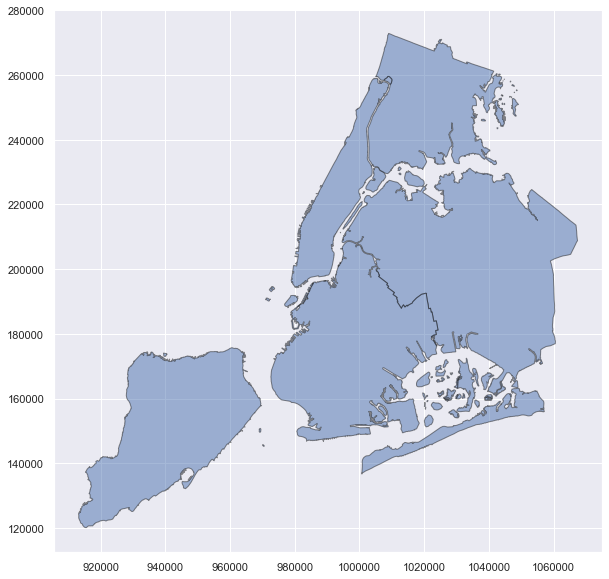

In [11]:
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

In [5]:
Location = namedtuple('Location', 'lng lat')

In [6]:
ESB = Location(lng=-73.9856, lat=40.7484)

In [11]:
getattr(ESB, 'lng')

-73.9856